In [1]:
# Copyright 2020 Bimghi Choi. All Rights Reserved.
# 예측 + 투자전략 시스템

# _*_ coding: utf-8 _*_

from tensorflow import keras
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]='0, 1'

In [2]:
import util
import preprocess as prepro
import models
import learn
from learn import GenerateResult
import math
from datetime import datetime

In [3]:
#tf.keras.backend.set_floatx('float64')

In [4]:
import gc
gc.collect()

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
  try:
#    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')    
    tf.config.experimental.set_visible_devices(gpus[1], 'GPU')    
    tf.config.experimental.set_virtual_device_configuration(
        gpus[1],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
  except RuntimeError as e:
    # 프로그램 시작시에 가장 장치가 설정되어야만 합니다
    print(e)

In [5]:
file_name = '~/Data/kospi200f_809_0515.csv'
item_name = 'kospi200f_reinfo_809'
train_start = '2000-01-31'
train_end = '2010-01-04'
test_start = '2010-01-04'
test_end = '2020-05-15'

remove_columns = ['date', '종가']
target_column = '종가'
input_columns = []
target_type = 'rate'

model_name = 'ddaeryuble6-4'
channel = False

trans_day = 10

target_alpha = 100
future_day = 20
train_end_back = -10
n_timestep = 100
time_interval = 1
input_size = 809
n_unit = 500
batch_size = 35
learning_rate = 0.0005
epochs = 1000

alpha = 0.05
beta = 0.01
gamma = 1

comment = "예측(sign) 모델과 value eval. 모델의 reinforcing interaction,  수익률의 합으로 평가, loss=loss_fn_model1"

checkpoint_path = model_name + "/pred"+str(future_day)+"_trans"+str(trans_day)+".ckpt"

In [6]:
dataframe = util.read_datafile(file_name)
df = dataframe.copy()
df['close'] = df[target_column] # 종가 column 추가, 기존 종가는 rate으로 변환 예정
a = []
b = []
#df = prepro.target_conversion(df, target_column, future_day, type=target_type)
for i in range(len(df[target_column]) -future_day):
    df.loc[i, target_column] = ((df.loc[i + future_day, target_column] - df.loc[i, target_column]) 
                                / df.loc[i, target_column]) * target_alpha     
   
    df.loc[i, '시가'] = df.loc[i + future_day + train_end_back + 1, '시가']
    a.append(max(df.loc[i  + future_day + train_end_back + 1:i + future_day + 1, '고가']))
    b.append(min(df.loc[i  + future_day + train_end_back + 1:i + future_day + 1, '저가']))
for i in range(len(df['종가']) - future_day):
    df.loc[i, '고가'] = a[i]
    df.loc[i, '저가'] = b[i]    

In [7]:
df.head(20)

,date,시가지수(포인트),고가지수(포인트),저가지수(포인트),종가지수(포인트),수익률(%),수익률 (1주)(%),수익률 (1개월)(%),수익률 (3개월)(%),수익률 (6개월)(%),...,주요상품선물_금(선물)($/ounce),주요상품선물_은(선물)($/ounce),주요상품선물_알루미늄(선물)($/ton),주요상품선물_옥수수(최근월물)(￠/bu),대두박(￠/bu),종가,시가,고가,저가,close
0,2000-01-31,-0.218225,-0.493106,-0.400439,-0.223565,0.212872,1.352924,-0.851790,-0.382658,-0.162615,...,-0.853010,0.974513,0.827681,0.373581,0.614542,-13.921405,112.05,115.70,100.75,119.60
1,2000-02-01,-0.213200,-0.230417,-0.373954,-0.595373,-0.407635,1.808646,-1.074203,-1.707405,-0.490731,...,-0.039689,0.193571,1.002058,0.594935,0.706918,-2.514088,112.35,115.70,100.75,115.35
2,2000-02-02,-0.208520,-0.448886,-0.367787,-0.200398,0.696677,2.107257,-0.769928,-1.558400,0.074389,...,0.800355,0.031266,0.069626,0.430159,0.725768,-5.994090,113.35,115.70,100.75,118.45
3,2000-02-03,-0.204125,-0.216603,-0.062403,-0.021445,0.366314,1.488978,-0.625155,-1.268930,-0.079967,...,1.515992,0.623370,0.378121,0.084769,0.352875,-5.241090,109.80,114.90,100.75,119.25
4,2000-02-07,-0.200000,0.378008,0.426748,0.592789,0.949260,1.101574,1.281908,-1.288431,1.273730,...,3.856851,0.568635,-0.322023,0.518339,0.702038,-7.151614,106.85,114.90,100.75,122.35
5,2000-02-08,-0.196110,0.353748,0.677387,0.254527,-0.366454,1.138729,0.998930,-1.329397,0.942469,...,2.657684,1.222974,-0.720402,0.474125,0.440887,-5.690722,108.55,115.85,100.75,121.25
6,2000-02-09,-0.192447,0.306497,0.819824,0.658684,0.641075,1.076862,1.233568,-1.637689,0.994675,...,3.026664,2.114708,-0.407511,0.622228,0.721716,-9.581811,110.20,115.85,100.75,123.15
7,2000-02-10,0.330923,0.617187,0.552762,0.366383,-0.311193,0.651653,0.275024,-1.607973,0.269679,...,3.316674,1.871659,-0.157431,0.985272,1.379493,-10.093610,107.75,115.85,100.75,122.85
8,2000-02-11,0.977388,0.576306,0.048738,-0.013448,-0.428351,0.326747,0.131530,-1.828185,0.546650,...,2.384344,0.988933,-0.154629,0.473525,0.907189,-15.059992,105.95,115.85,100.75,120.85
9,2000-02-14,-0.649462,-0.806483,-0.954529,-1.222378,-1.533955,-1.217328,-0.075927,-2.486079,0.140712,...,1.935983,0.085505,-0.246361,0.529501,0.923675,-10.474138,104.15,115.85,99.15,116.00


In [8]:
@tf.function
def loss_fn_model1_1(targets, preds):
 
    loss0 = tf.keras.losses.MSE(tf.sign(targets), preds)
    
        
    if alpha != 0:
        # add RRL cost - maximize downside sharp ratio

        # 1 if (pred - base) * (target - base) > 0, -1 otherwise
        F = tf.math.sign(targets*preds)

        # calc returns from each step in batches
        R = tf.math.multiply(tf.math.abs(targets), (F - 0.00003)) / target_alpha

        # downside returns
        DR = tf.minimum(0.0, R)

        loss1 = tf.reduce_mean(R) / (tf.keras.backend.std(DR) + 0.001)
    else:
        loss1 = 0

    # maximum drawdown 계산        
    if beta != 0:

        accm_profit = tf.cumsum(F * tf.math.abs(targets), axis=1)

        loss2 = tf.divide(tf.reduce_max(accm_profit) - tf.reduce_min(accm_profit), tf.cast(len(accm_profit), dtype=tf.float32))
    
    else:
        loss2 = 0

    return loss0 + beta*loss2 - alpha*loss1

In [9]:
@tf.function
def loss_fn_model1(train_y, preds):
    
    #preds = tf.cast(preds, dtype=tf.float64)
    #train_y = tf.cast(train_y, dtype=tf.float64)
    rates = train_y / 100
    updown = tf.math.sign(train_y)
    profits = rates*tf.math.sign(preds)
    
    loss1 = keras.losses.MSE(tf.sign(train_y), preds)
    

    return_plus = profits[profits>0]
    return_minus = profits[profits<=0]
 

    loss2 = tf.reduce_mean(return_plus) + tf.reduce_mean(return_minus)
    
    return loss1 - loss2 * beta


In [10]:
@tf.function
def loss_fn_model2(m1, m2, train_x, train_y):
    
    batches = train_y.shape[0]
    steps = train_y.shape[1]    
    
   
    train_y_target = tf.expand_dims(train_y[:, :, 4], axis=2)
    
    rates = tf.cast(train_y_target / 100, dtype=tf.float64)
    #rates_last = tf.reshape(rates[:, -1, 0], [-1])
    #rates = tf.reshape(rates[:, :-1, 0], [batches, steps - 1, 1])
    #rates = tf.concat([rates, np.zeros((batches, 1, 1))], 1)
    #updown = tf.math.sign(train_y_target)
    preds = tf.cast(m1(train_x), dtype=tf.float64)
    #profits = tf.cast(tf.convert_to_tensor(rates, dtype=tf.float64)*tf.math.sign(preds), dtype=tf.float64)
    
    train_y_close = tf.reshape(train_y[:, :, 3], [batches, steps])
    
    # model2 input 생성
    y = tf.reshape(tf.cast(m2(train_y_close), dtype=tf.float64), [-1])
    
    # the number of shares 계산
    rewards = []
    for i in range(batches):
        rewards.append((train_y_close[i, -1] - train_y_close[i, -2]) / train_y_close[i, -2] * \
                        tf.sign(preds[i, -2, 0]) * train_y_close[i, -2] / train_y_close[i, 0])
  
    targets = (rewards + 0.1*tf.reshape(rates[:, -1, 0], [-1]) * tf.sign(tf.reshape(preds[:, -1, 0], [-1])))*100
   

    loss = keras.losses.MSE(targets, y)
    
    loss_model1 = keras.losses.MSE(tf.sign(y), tf.reshape(preds[:, -1, 0], [-1]))
  
    return loss + loss_model1


In [11]:
def test(m1, m2, test_x, test_y):
    
    #test_y_target = np.expand_dims(test_y[:, :, 4], axis=2)
    
    #rates = tf.cast(test_y_target / 100, dtype=tf.float64)
    #rates = tf.reshape(rates[:, :-1, 0], [rates.shape[0], rates.shape[1] -1, 1])
    #rates = tf.concat([rates, np.zeros((rates.shape[0], 1, 1))], 1)
    #preds = tf.cast(m1(test_x), dtype=tf.float64)

    # model2 input 생성
    #test_x_m2 = tf.concat([preds, rates], 2)
    
    # 종가 데이터
    test_y_close = tf.reshape(test_y[:, :, 3], [test_y.shape[0], test_y.shape[1]])
    y = tf.reshape(m2(test_y_close), [-1])

    return y

In [12]:
#@tf.function
def gradient1(model1, model2, input_data, output_data):
    with tf.GradientTape() as tape:
        loss = loss_fn_model2(model1, model2, input_data, output_data)
    return tape.gradient(loss, model1.trainable_variables)
#@tf.function
def gradient2(model1, model2, input_data, output_data):
    with tf.GradientTape() as tape:
        loss = loss_fn_model2(model1, model2, input_data, output_data)
    return tape.gradient(loss, model2.trainable_variables)

In [13]:
#strategy = tf.distribute.MirroredStrategy()
#with strategy.scope():
model1 = models.LSTM_tanh(n_timestep,input_size,n_unit,regularizers_alpha=0.01,drop_rate=0.5)
#model2 = models.LSTM_sigm(n_timestep,2,10,regularizers_alpha=0.01,drop_rate=0)

model2 = tf.keras.Sequential([
    tf.keras.Input(shape=(100)),
    tf.keras.layers.Dense(50, kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(20, kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(1),
])
model2.summary()

    #cp_callback = tf.keras.callbacks.ModelCheckpoint(
    #    checkpoint_path, verbose=1, save_weights_only=True,
        # 다섯 번째 에포크마다 가중치를 저장합니다
    #    save_freq=5)

model1.compile(optimizer='adam',
              loss=loss_fn_model1)
                  #callbacks=[cp-callback]
              #metrics=['accuracy'])
#model1.save_weights(checkpoint_path)            

#    model2 = models.LSTM(n_timestep,input_size,n_unit,regularizers_alpha=0.01,drop_rate=0.5)
#    model2.compile(optimizer='adam',
#                  loss='mse')
                  #callbacks=[cp-callback]
              #metrics=['accuracy'])            

#modle_name = model_name + "tanh"            
#model2.save_weights("modle2_"+ checkpoint_path)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 6,091
Trainable params: 6,091
Non-trainable params: 0
_________________________________________________________________


In [14]:
current_train_start = df.loc[prepro.date_to_index(df, train_start), 'date']
current_train_end = df.loc[prepro.date_to_index(df, train_end), 'date']
current_test_start = df.loc[prepro.date_to_index(df, test_start), 'date']
current_test_end = df.loc[prepro.date_to_index(df, test_start) + trans_day - 1, 'date']


#  각 transfer 구간의 예측값들을 합치기 위하여
test_prediction1 = []
test_prediction2 = []

print("실험 시작")
print(datetime.now().strftime("%Y-%m-%d:%H:%M:%S"))

while True:

    gc.collect()
    
    #model2 data
    train_data, test_data = prepro.get_train_test_data(df, target_column, remove_columns, 
                                                           current_train_start, current_train_end,
                                                           current_test_start, current_test_end,
                                                           future_day, n_timestep, time_interval)


    train_x, train_y = prepro.get_LSTM_dataset(train_data, n_timestep, time_interval, input_size, future_day)
    
    # randomly selected  step size
    #drop_idx = np.random.randint(int(train_y.shape[1]/2))
    #train_x[:, :drop_idx, :] = 0
    #train_y[:, :drop_idx, :] = 0    
    
    train_x = train_x[:train_end_back]
    train_y = train_y[:train_end_back]
    
    test_x, test_y = prepro.get_LSTM_dataset(test_data, n_timestep, time_interval, input_size, future_day)
    test_y_target = np.expand_dims(test_y[:, :, 4], axis=2)    
    
    # train, validation set 분리하여 train1은 예측모델로 train2는 손절값 학습 모델로 사용
    train1_x, train2_x, train1_y, train2_y = train_test_split(train_x, train_y, test_size=0.5)    
    
    updown = np.sign(test_y[:, -1, 4]).reshape((-1))
    
    # random batch_size
    #batch_size = np.random.randint(10, 50)    

    # model1 training
    train1_y_target = np.expand_dims(train1_y[:, :, 4], axis=2)
    early_stopping1 = tf.keras.callbacks.EarlyStopping(patience=2, verbose=1)
    #model1.load_weights(checkpoint_path)
    model1.fit(train1_x, train1_y_target, batch_size=batch_size, epochs=3, callbacks=[early_stopping1], validation_data=(test_x, test_y_target))
    #model1.save_weights(checkpoint_path)
    
    # 자산 배분 모델 reset
    #model2 = tf.keras.Sequential([
    #    tf.keras.Input(shape=(n_timestep, 2)),
    #    tf.keras.layers.LSTM(10, return_sequences=True, kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    #    tf.keras.layers.Dense(64, activation='relu'),
    #    tf.keras.layers.Dense(3, activation='softmax'),
    #])    
    
    # model2 training
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)    
    early_stopping2 = learn.EarlyStopping(patience=2, verbose=1)
    iter = epochs
    basic_epochs = tf.cast(epochs / 5, dtype=tf.int32)
    for iteration in range(iter):
        batch_input, batch_output = learn.next_random_batch(train2_x, train2_y, batch_size)

        gradients1 = gradient1(model1, model2, batch_input, batch_output)
        optimizer.apply_gradients(zip(gradients1, model1.trainable_variables))
        gradients2 = gradient2(model1, model2, batch_input, batch_output)        
        optimizer.apply_gradients(zip(gradients2, model2.trainable_variables))

        if iteration % 100 == 0:

            # model2의 test loss
            loss2 = loss_fn_model2(model1, model2, test_x, test_y)
            print('model2 loss =', loss2)   

        if iteration > iter / 2 and early_stopping2.validate(loss2)==True:
            break    

    if iter > basic_epochs: iter -= basic_epochs
    if iter < basic_epochs: iter = basic_epochs

    print('test dates ' + current_test_start + "~" + current_test_end)

    # prediction1 accuracy
    prediction1 = model1.predict(test_x)[:, -1, 0].reshape(-1)
    temp = tf.math.multiply(updown, prediction1)
    accu = tf.reduce_sum(list(map(lambda x: 1 if x > 0 else 0, temp)))/len(temp)
    print('prediction1 accuracy = ', accu)

    # reinforced prediction2
    prediction2 = test(model1, model2, test_x, test_y)    
    temp = tf.math.multiply(updown, prediction2)
    temp_plus = temp[temp>0]
    print('prediction1 accuracy2 = ', len(temp_plus) /len(temp))
 
    test_prediction1.append(prediction1)
    test_prediction2.append(prediction2)

    # escape from while
    if current_test_end == test_end:
     break

    #train, start dates shift
    current_train_end = df.loc[prepro.date_to_index(df, current_train_end) + trans_day, 'date']
    current_train_start = df.loc[prepro.date_to_index(df, current_train_end) - 1000, 'date']
    current_test_start = df.loc[prepro.date_to_index(df, current_test_start) + trans_day, 'date']
    if prepro.date_to_index(df, test_end) - prepro.date_to_index(df, current_test_start) < trans_day:
        current_test_end = test_end
    else:
        current_test_end = df.loc[prepro.date_to_index(df, current_test_end) + trans_day, 'date']

실험 시작
2020-10-06:21:07:33
Train on 1161 samples, validate on 10 samples
Epoch 1/3
1161/1161 [==============================] - 9s 8ms/sample - loss: 52.9056 - val_loss: 29.5146
Epoch 2/3
1161/1161 [==============================] - 2s 2ms/sample - loss: 18.2713 - val_loss: 10.1681
Epoch 3/3
1161/1161 [==============================] - 1s 1ms/sample - loss: 6.0393 - val_loss: 3.6187

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only

Train on 436 samples, validate on 10 samples
Epoch 1/3
436/436 [==============================] - 1s 1ms/sample - loss: 4.7174 - val_loss: 2.7270
Epoch 2/3
436/436 [==============================] - 0s 1ms/sample - loss: 1.4625 - val_loss: 0.9890
Epoch 3/3
436/436 [==============================] - 1s 2ms/sample - loss: 0.5728 - val_loss: 0.4369
model2 loss = tf.Tensor(8171.894964474488, shape=(), dtype=float64)
model2 loss = tf.Tensor(18.409693482872576, shape=(), dtype=float64)
model2 loss = tf.Tensor(19.352591079309967, shape=(), dtype=float64)
model2 loss = tf.Tensor(55.35326549263862, shape=(), dtype=float64)
model2 loss = tf.Tensor(28.90215779130876, shape=(), dtype=float64)
model2 loss = tf.Tensor(17.494206506986675, shape=(), dtype=float64)
model2 loss = tf.Tensor(15.962059400134033, shape=(), dtype=float64)
model2 loss = tf.Tensor(39.96013857485096, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2010-03-31~2010-04-13
pre

model2 loss = tf.Tensor(10.00098909698098, shape=(), dtype=float64)
model2 loss = tf.Tensor(8.690426171906415, shape=(), dtype=float64)
model2 loss = tf.Tensor(63.70699685041519, shape=(), dtype=float64)
model2 loss = tf.Tensor(11.52122891644008, shape=(), dtype=float64)
model2 loss = tf.Tensor(8.374060181714782, shape=(), dtype=float64)
model2 loss = tf.Tensor(23.089146215779408, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2010-07-12~2010-07-23
prediction1 accuracy =  tf.Tensor(0.3, shape=(), dtype=float64)
prediction1 accuracy2 =  0.2
Train on 436 samples, validate on 10 samples
Epoch 1/3
436/436 [==============================] - 1s 1ms/sample - loss: 6.1802 - val_loss: 2.9824
Epoch 2/3
436/436 [==============================] - 0s 1ms/sample - loss: 1.4971 - val_loss: 1.0378
Epoch 3/3
436/436 [==============================] - 1s 1ms/sample - loss: 0.4591 - val_loss: 0.6522
model2 loss = tf.Tensor(6190.656100042762, shape=

436/436 [==============================] - 1s 2ms/sample - loss: 5.2646 - val_loss: 2.5510
Epoch 2/3
436/436 [==============================] - 1s 2ms/sample - loss: 1.1117 - val_loss: 0.7311
Epoch 3/3
436/436 [==============================] - 1s 2ms/sample - loss: 0.3672 - val_loss: 0.3247
model2 loss = tf.Tensor(3879.519372334132, shape=(), dtype=float64)
model2 loss = tf.Tensor(5.479026457283973, shape=(), dtype=float64)
model2 loss = tf.Tensor(4.621256663430215, shape=(), dtype=float64)
model2 loss = tf.Tensor(28.780421395197273, shape=(), dtype=float64)
model2 loss = tf.Tensor(7.941246160929929, shape=(), dtype=float64)
model2 loss = tf.Tensor(3.9867547527162834, shape=(), dtype=float64)
model2 loss = tf.Tensor(3.9978817970444744, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2010-11-04~2010-11-17
prediction1 accuracy =  tf.Tensor(0.6, shape=(), dtype=float64)
prediction1 accuracy2 =  0.8
Train on 436 samples, validate on 

Train on 436 samples, validate on 10 samples
Epoch 1/3
436/436 [==============================] - 1s 2ms/sample - loss: 3.5577 - val_loss: 1.3990
Epoch 2/3
436/436 [==============================] - 1s 2ms/sample - loss: 0.7358 - val_loss: 0.4400
Epoch 3/3
436/436 [==============================] - 1s 2ms/sample - loss: 0.2883 - val_loss: 0.2972
model2 loss = tf.Tensor(4310.390596758325, shape=(), dtype=float64)
model2 loss = tf.Tensor(6.481656214096853, shape=(), dtype=float64)
model2 loss = tf.Tensor(6.039685196936647, shape=(), dtype=float64)
model2 loss = tf.Tensor(8.631460085962834, shape=(), dtype=float64)
model2 loss = tf.Tensor(21.411392611957112, shape=(), dtype=float64)
model2 loss = tf.Tensor(14.400868883225666, shape=(), dtype=float64)
model2 loss = tf.Tensor(17.83432573193609, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2011-03-03~2011-03-16
prediction1 accuracy =  tf.Tensor(0.3, shape=(), dtype=float64)
predictio

Train on 436 samples, validate on 10 samples
Epoch 1/3
436/436 [==============================] - 1s 1ms/sample - loss: 5.4285 - val_loss: 2.5675
Epoch 2/3
436/436 [==============================] - 0s 1ms/sample - loss: 0.9680 - val_loss: 0.9515
Epoch 3/3
436/436 [==============================] - 0s 1ms/sample - loss: 0.3566 - val_loss: 0.7332
model2 loss = tf.Tensor(2875.173472251887, shape=(), dtype=float64)
model2 loss = tf.Tensor(3.9984730041798002, shape=(), dtype=float64)
model2 loss = tf.Tensor(10.601798307940447, shape=(), dtype=float64)
model2 loss = tf.Tensor(2.3214591256255357, shape=(), dtype=float64)
model2 loss = tf.Tensor(2.8573225058613447, shape=(), dtype=float64)
model2 loss = tf.Tensor(3.4565373908387915, shape=(), dtype=float64)
model2 loss = tf.Tensor(7.6137900971903045, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2011-06-28~2011-07-11
prediction1 accuracy =  tf.Tensor(0.2, shape=(), dtype=float64)
predi

step :  2
step :  3
Training process is stopped early....
test dates 2011-10-10~2011-10-21
prediction1 accuracy =  tf.Tensor(0.6, shape=(), dtype=float64)
prediction1 accuracy2 =  0.4
Train on 436 samples, validate on 10 samples
Epoch 1/3
436/436 [==============================] - 1s 2ms/sample - loss: 6.2320 - val_loss: 3.9493
Epoch 2/3
436/436 [==============================] - 1s 2ms/sample - loss: 2.6300 - val_loss: 2.4023
Epoch 3/3
436/436 [==============================] - 1s 2ms/sample - loss: 1.4978 - val_loss: 1.6171
model2 loss = tf.Tensor(2120.166752295911, shape=(), dtype=float64)
model2 loss = tf.Tensor(9.07453369833247, shape=(), dtype=float64)
model2 loss = tf.Tensor(12.839312910837496, shape=(), dtype=float64)
model2 loss = tf.Tensor(14.341128965199275, shape=(), dtype=float64)
model2 loss = tf.Tensor(16.56570569769272, shape=(), dtype=float64)
model2 loss = tf.Tensor(11.480466961059566, shape=(), dtype=float64)
model2 loss = tf.Tensor(7.357606641652322, shape=(), dtype

436/436 [==============================] - 0s 1ms/sample - loss: 0.5563 - val_loss: 0.8911
model2 loss = tf.Tensor(689.6993363468704, shape=(), dtype=float64)
model2 loss = tf.Tensor(4.313885117296237, shape=(), dtype=float64)
model2 loss = tf.Tensor(11.269567791312493, shape=(), dtype=float64)
model2 loss = tf.Tensor(5.0602632160799725, shape=(), dtype=float64)
model2 loss = tf.Tensor(5.025424486482166, shape=(), dtype=float64)
model2 loss = tf.Tensor(3.8895571305602483, shape=(), dtype=float64)
model2 loss = tf.Tensor(6.551782138115348, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2012-02-02~2012-02-15
prediction1 accuracy =  tf.Tensor(0.4, shape=(), dtype=float64)
prediction1 accuracy2 =  0.7
Train on 436 samples, validate on 10 samples
Epoch 1/3
436/436 [==============================] - 1s 2ms/sample - loss: 4.8138 - val_loss: 2.7669
Epoch 2/3
436/436 [==============================] - 1s 2ms/sample - loss: 1.1705 - val_lo

436/436 [==============================] - 1s 2ms/sample - loss: 5.0154 - val_loss: 3.0238
Epoch 2/3
436/436 [==============================] - 1s 2ms/sample - loss: 1.1151 - val_loss: 1.5207
Epoch 3/3
436/436 [==============================] - 1s 1ms/sample - loss: 0.5189 - val_loss: 1.1874
model2 loss = tf.Tensor(400.2887322687072, shape=(), dtype=float64)
model2 loss = tf.Tensor(4.866809824025633, shape=(), dtype=float64)
model2 loss = tf.Tensor(4.171147601887573, shape=(), dtype=float64)
model2 loss = tf.Tensor(4.8391865515756525, shape=(), dtype=float64)
model2 loss = tf.Tensor(4.5821644397196915, shape=(), dtype=float64)
model2 loss = tf.Tensor(2.4015840895439764, shape=(), dtype=float64)
model2 loss = tf.Tensor(20.93846229737436, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2012-05-30~2012-06-13
prediction1 accuracy =  tf.Tensor(0.0, shape=(), dtype=float64)
prediction1 accuracy2 =  1.0
Train on 436 samples, validate on 

step :  2
step :  3
Training process is stopped early....
test dates 2012-09-07~2012-09-20
prediction1 accuracy =  tf.Tensor(0.5, shape=(), dtype=float64)
prediction1 accuracy2 =  0.3
Train on 436 samples, validate on 10 samples
Epoch 1/3
436/436 [==============================] - 1s 2ms/sample - loss: 4.1731 - val_loss: 2.0994
Epoch 2/3
436/436 [==============================] - 0s 1ms/sample - loss: 0.9219 - val_loss: 0.8959
Epoch 3/3
436/436 [==============================] - 0s 1ms/sample - loss: 0.4323 - val_loss: 0.7187
model2 loss = tf.Tensor(14.94737423991485, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.678694321785395, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.406270363001187, shape=(), dtype=float64)
model2 loss = tf.Tensor(3.6317051317768483, shape=(), dtype=float64)
model2 loss = tf.Tensor(2.6921840342596686, shape=(), dtype=float64)
model2 loss = tf.Tensor(2.5440295730313824, shape=(), dtype=float64)
model2 loss = tf.Tensor(2.1354018892305646, shape=(), dty

model2 loss = tf.Tensor(2.0199113126505495, shape=(), dtype=float64)
model2 loss = tf.Tensor(2.0710447255462974, shape=(), dtype=float64)
model2 loss = tf.Tensor(3.3332478966848753, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.3605398482191071, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.0400352911018487, shape=(), dtype=float64)
model2 loss = tf.Tensor(3.4409368019121427, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2013-01-07~2013-01-18
prediction1 accuracy =  tf.Tensor(0.6, shape=(), dtype=float64)
prediction1 accuracy2 =  0.6
Train on 436 samples, validate on 10 samples
Epoch 1/3
436/436 [==============================] - 1s 2ms/sample - loss: 4.5310 - val_loss: 2.3091
Epoch 2/3
436/436 [==============================] - 0s 1ms/sample - loss: 1.0531 - val_loss: 0.8513
Epoch 3/3
436/436 [==============================] - 0s 1ms/sample - loss: 0.4734 - val_loss: 0.6471
model2 loss = tf.Tensor(5.337803951525471, s

model2 loss = tf.Tensor(2.274731562014254, shape=(), dtype=float64)
model2 loss = tf.Tensor(3.855202682868212, shape=(), dtype=float64)
model2 loss = tf.Tensor(3.6449323513934857, shape=(), dtype=float64)
model2 loss = tf.Tensor(2.114022068614399, shape=(), dtype=float64)
model2 loss = tf.Tensor(2.419731473855784, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2013-05-02~2013-05-15
prediction1 accuracy =  tf.Tensor(0.7, shape=(), dtype=float64)
prediction1 accuracy2 =  0.3
Train on 436 samples, validate on 10 samples
Epoch 1/3
436/436 [==============================] - 1s 2ms/sample - loss: 2.9647 - val_loss: 1.8349
Epoch 2/3
436/436 [==============================] - 1s 2ms/sample - loss: 0.6696 - val_loss: 0.9178
Epoch 3/3
436/436 [==============================] - 1s 2ms/sample - loss: 0.3535 - val_loss: 0.7297
model2 loss = tf.Tensor(2.640377591708924, shape=(), dtype=float64)
model2 loss = tf.Tensor(5.206472603835982, shape=

436/436 [==============================] - 1s 1ms/sample - loss: 0.8949 - val_loss: 0.9302
Epoch 3/3
436/436 [==============================] - 1s 1ms/sample - loss: 0.4642 - val_loss: 0.6148
model2 loss = tf.Tensor(3.793469951623133, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.8376209476609413, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.5580112031868594, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.4569322939379385, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.5898135306337142, shape=(), dtype=float64)
model2 loss = tf.Tensor(2.468999339594677, shape=(), dtype=float64)
model2 loss = tf.Tensor(3.097652035095858, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2013-08-27~2013-09-09
prediction1 accuracy =  tf.Tensor(0.8, shape=(), dtype=float64)
prediction1 accuracy2 =  0.3
Train on 436 samples, validate on 10 samples
Epoch 1/3
436/436 [==============================] - 1s 1ms/sample - loss: 3.7751 - val_l

model2 loss = tf.Tensor(2.0526396519246157, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2013-12-10~2013-12-23
prediction1 accuracy =  tf.Tensor(0.1, shape=(), dtype=float64)
prediction1 accuracy2 =  0.7
Train on 436 samples, validate on 10 samples
Epoch 1/3
436/436 [==============================] - 1s 2ms/sample - loss: 5.7498 - val_loss: 2.7575
Epoch 2/3
436/436 [==============================] - 1s 1ms/sample - loss: 1.1590 - val_loss: 1.2083
Epoch 3/3
436/436 [==============================] - 1s 1ms/sample - loss: 0.5256 - val_loss: 0.8618
model2 loss = tf.Tensor(3.1487039215611174, shape=(), dtype=float64)
model2 loss = tf.Tensor(2.0909061712014507, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.5585219243557658, shape=(), dtype=float64)
model2 loss = tf.Tensor(2.5640903051557844, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.3457957187682161, shape=(), dtype=float64)
model2 loss = tf.Tensor(2.7367651559485964, 

436/436 [==============================] - 1s 2ms/sample - loss: 0.8840 - val_loss: 1.1448
Epoch 3/3
436/436 [==============================] - 1s 2ms/sample - loss: 0.4633 - val_loss: 0.9062
model2 loss = tf.Tensor(5.388410927924978, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.68529992276647, shape=(), dtype=float64)
model2 loss = tf.Tensor(2.7110364243511733, shape=(), dtype=float64)
model2 loss = tf.Tensor(2.2267225106132758, shape=(), dtype=float64)
model2 loss = tf.Tensor(2.026439256885139, shape=(), dtype=float64)
model2 loss = tf.Tensor(2.0102161458810093, shape=(), dtype=float64)
model2 loss = tf.Tensor(2.0407398447811955, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2014-04-08~2014-04-21
prediction1 accuracy =  tf.Tensor(0.7, shape=(), dtype=float64)
prediction1 accuracy2 =  1.0
Train on 436 samples, validate on 10 samples
Epoch 1/3
436/436 [==============================] - 1s 2ms/sample - loss: 3.4318 - val_lo

step :  3
Training process is stopped early....
test dates 2014-07-22~2014-08-04
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction1 accuracy2 =  0.0
Train on 436 samples, validate on 10 samples
Epoch 1/3
436/436 [==============================] - 1s 2ms/sample - loss: 6.6992 - val_loss: 3.3919
Epoch 2/3
436/436 [==============================] - 1s 2ms/sample - loss: 1.7998 - val_loss: 1.6919
Epoch 3/3
436/436 [==============================] - 1s 1ms/sample - loss: 0.9206 - val_loss: 1.2601
model2 loss = tf.Tensor(4.664380533885951, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.7806693064933267, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.4655667852630825, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.654554203974793, shape=(), dtype=float64)
model2 loss = tf.Tensor(2.2660888955304035, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.8102326891812494, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.2826024195643853, shape=(), dtype=float6

model2 loss = tf.Tensor(1.2516837584594627, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.0448150993838339, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.2540177208421728, shape=(), dtype=float64)
model2 loss = tf.Tensor(2.8865143486973244, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2014-11-19~2014-12-02
prediction1 accuracy =  tf.Tensor(0.9, shape=(), dtype=float64)
prediction1 accuracy2 =  1.0
Train on 436 samples, validate on 10 samples
Epoch 1/3
436/436 [==============================] - 1s 2ms/sample - loss: 6.6154 - val_loss: 3.0378
Epoch 2/3
436/436 [==============================] - 1s 2ms/sample - loss: 1.6418 - val_loss: 1.4895
Epoch 3/3
436/436 [==============================] - 1s 2ms/sample - loss: 1.0450 - val_loss: 1.2393
model2 loss = tf.Tensor(2.5455865668810063, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.4769680737980606, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.5772118230474086, 

Epoch 2/3
436/436 [==============================] - 1s 1ms/sample - loss: 1.7390 - val_loss: 1.7349
Epoch 3/3
436/436 [==============================] - 0s 1ms/sample - loss: 0.8366 - val_loss: 1.2930
model2 loss = tf.Tensor(4.141948835189611, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.6209076919727492, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.4939371771505465, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.7353691428473086, shape=(), dtype=float64)
model2 loss = tf.Tensor(2.4136945694820806, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.8497230621417435, shape=(), dtype=float64)
model2 loss = tf.Tensor(2.232410452325382, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2015-03-19~2015-04-01
prediction1 accuracy =  tf.Tensor(0.9, shape=(), dtype=float64)
prediction1 accuracy2 =  0.9
Train on 436 samples, validate on 10 samples
Epoch 1/3
436/436 [==============================] - 1s 1ms/sample - loss: 6.4

model2 loss = tf.Tensor(1.551536334928344, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2015-06-30~2015-07-13
prediction1 accuracy =  tf.Tensor(0.5, shape=(), dtype=float64)
prediction1 accuracy2 =  0.1
Train on 436 samples, validate on 10 samples
Epoch 1/3
436/436 [==============================] - 1s 1ms/sample - loss: 4.8829 - val_loss: 2.5250
Epoch 2/3
436/436 [==============================] - 1s 1ms/sample - loss: 1.4503 - val_loss: 1.1025
Epoch 3/3
436/436 [==============================] - 1s 2ms/sample - loss: 0.7323 - val_loss: 0.7540
model2 loss = tf.Tensor(2.926251090425066, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.9040001971925928, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.2433914015676055, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.2047366282563914, shape=(), dtype=float64)
model2 loss = tf.Tensor(3.1374469352550003, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.390881974457903, sha

model2 loss = tf.Tensor(0.7884026365437871, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.9202825094838891, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.8313975515102051, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.233900682008648, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.3542927850499873, shape=(), dtype=float64)
model2 loss = tf.Tensor(4.070121042062187, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2015-10-26~2015-11-06
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction1 accuracy2 =  0.0
Train on 436 samples, validate on 10 samples
Epoch 1/3
436/436 [==============================] - 1s 2ms/sample - loss: 4.5032 - val_loss: 2.0628
Epoch 2/3
436/436 [==============================] - 1s 2ms/sample - loss: 1.3239 - val_loss: 0.9956
Epoch 3/3
436/436 [==============================] - 1s 2ms/sample - loss: 0.6942 - val_loss: 0.6702
model2 loss = tf.Tensor(0.7251711994016543, sh

step :  2
step :  3
Training process is stopped early....
test dates 2016-02-04~2016-02-22
prediction1 accuracy =  tf.Tensor(0.6, shape=(), dtype=float64)
prediction1 accuracy2 =  0.6
Train on 436 samples, validate on 10 samples
Epoch 1/3
436/436 [==============================] - 1s 2ms/sample - loss: 5.1448 - val_loss: 2.7544
Epoch 2/3
436/436 [==============================] - 1s 1ms/sample - loss: 1.3764 - val_loss: 1.2336
Epoch 3/3
436/436 [==============================] - 0s 1ms/sample - loss: 0.7219 - val_loss: 0.8877
model2 loss = tf.Tensor(1.1402660778288884, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.088881028601804, shape=(), dtype=float64)
model2 loss = tf.Tensor(5.4028583973144935, shape=(), dtype=float64)
model2 loss = tf.Tensor(2.807182453543145, shape=(), dtype=float64)
model2 loss = tf.Tensor(2.233260666515746, shape=(), dtype=float64)
model2 loss = tf.Tensor(3.692367709465942, shape=(), dtype=float64)
model2 loss = tf.Tensor(3.7939418131892695, shape=(), dtyp

model2 loss = tf.Tensor(2.4140280856035616, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2016-06-07~2016-06-20
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction1 accuracy2 =  0.0
Train on 436 samples, validate on 10 samples
Epoch 1/3
436/436 [==============================] - 1s 1ms/sample - loss: 4.0053 - val_loss: 2.0847
Epoch 2/3
436/436 [==============================] - 0s 1ms/sample - loss: 1.0912 - val_loss: 0.9911
Epoch 3/3
436/436 [==============================] - 1s 2ms/sample - loss: 0.6163 - val_loss: 0.7034
model2 loss = tf.Tensor(0.7721492689854825, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.31583471560974224, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.5904687419609855, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.6969971235338739, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.7112532092023636, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.8696860463568084,

model2 loss = tf.Tensor(2.513061500382131, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.8588845915797954, shape=(), dtype=float64)
model2 loss = tf.Tensor(2.7398495048274225, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2016-10-04~2016-10-17
prediction1 accuracy =  tf.Tensor(0.7, shape=(), dtype=float64)
prediction1 accuracy2 =  0.3
Train on 436 samples, validate on 10 samples
Epoch 1/3
436/436 [==============================] - 1s 1ms/sample - loss: 3.3490 - val_loss: 2.4876
Epoch 2/3
436/436 [==============================] - 1s 1ms/sample - loss: 0.9087 - val_loss: 1.5962
Epoch 3/3
436/436 [==============================] - 1s 2ms/sample - loss: 0.5690 - val_loss: 0.9206
model2 loss = tf.Tensor(2.1853459346237383, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.5969769310882412, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.2645812617519734, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.130699287893771, sh

model2 loss = tf.Tensor(1.8641950650793968, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.549964445653821, shape=(), dtype=float64)
model2 loss = tf.Tensor(2.6376172836218057, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2017-01-25~2017-02-09
prediction1 accuracy =  tf.Tensor(1.0, shape=(), dtype=float64)
prediction1 accuracy2 =  0.0
Train on 436 samples, validate on 10 samples
Epoch 1/3
436/436 [==============================] - 1s 2ms/sample - loss: 8.3374 - val_loss: 4.0804
Epoch 2/3
436/436 [==============================] - 0s 1ms/sample - loss: 1.8801 - val_loss: 2.2488
Epoch 3/3
436/436 [==============================] - 0s 1ms/sample - loss: 0.8999 - val_loss: 1.6656
model2 loss = tf.Tensor(3.9106993761053124, shape=(), dtype=float64)
model2 loss = tf.Tensor(2.597193637296777, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.4924785854250895, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.088882986270681, sha

436/436 [==============================] - 1s 2ms/sample - loss: 4.4348 - val_loss: 2.7961
Epoch 2/3
436/436 [==============================] - 1s 1ms/sample - loss: 1.0789 - val_loss: 1.7846
Epoch 3/3
436/436 [==============================] - 1s 1ms/sample - loss: 0.6082 - val_loss: 1.5041
model2 loss = tf.Tensor(8.14565228956079, shape=(), dtype=float64)
model2 loss = tf.Tensor(5.01117347589956, shape=(), dtype=float64)
model2 loss = tf.Tensor(4.489070767710135, shape=(), dtype=float64)
model2 loss = tf.Tensor(3.443497327353859, shape=(), dtype=float64)
model2 loss = tf.Tensor(4.80660112587843, shape=(), dtype=float64)
model2 loss = tf.Tensor(4.060446008035473, shape=(), dtype=float64)
model2 loss = tf.Tensor(4.499393811269466, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2017-05-26~2017-06-09
prediction1 accuracy =  tf.Tensor(0.5, shape=(), dtype=float64)
prediction1 accuracy2 =  0.1
Train on 436 samples, validate on 10 sam

Train on 436 samples, validate on 10 samples
Epoch 1/3
436/436 [==============================] - 1s 1ms/sample - loss: 4.8506 - val_loss: 2.8259
Epoch 2/3
436/436 [==============================] - 0s 1ms/sample - loss: 1.0929 - val_loss: 1.3035
Epoch 3/3
436/436 [==============================] - 0s 1ms/sample - loss: 0.5866 - val_loss: 0.9690
model2 loss = tf.Tensor(1.485753440348231, shape=(), dtype=float64)
model2 loss = tf.Tensor(2.9166463507347253, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.8774246246984263, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.5895223982739175, shape=(), dtype=float64)
model2 loss = tf.Tensor(2.2958686733459825, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.318219760314482, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.5322731855786467, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2017-09-19~2017-10-10
prediction1 accuracy =  tf.Tensor(0.9, shape=(), dtype=float64)
predic

model2 loss = tf.Tensor(1.2498798299860276, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.070103202373977, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.055407882279893, shape=(), dtype=float64)
model2 loss = tf.Tensor(2.55277332596584, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2018-01-08~2018-01-19
prediction1 accuracy =  tf.Tensor(0.8, shape=(), dtype=float64)
prediction1 accuracy2 =  1.0
Train on 436 samples, validate on 10 samples
Epoch 1/3
436/436 [==============================] - 1s 2ms/sample - loss: 7.1085 - val_loss: 2.8593
Epoch 2/3
436/436 [==============================] - 1s 1ms/sample - loss: 1.3662 - val_loss: 1.2645
Epoch 3/3
436/436 [==============================] - 0s 1ms/sample - loss: 0.6597 - val_loss: 1.0065
model2 loss = tf.Tensor(1.7785516247132855, shape=(), dtype=float64)
model2 loss = tf.Tensor(2.470268628696834, shape=(), dtype=float64)
model2 loss = tf.Tensor(2.3930345792110552, shape

Epoch 3/3
436/436 [==============================] - 1s 2ms/sample - loss: 0.4531 - val_loss: 0.7288
model2 loss = tf.Tensor(1.8679142930814805, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.5065793452665855, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.9281619692377238, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.6647892435055864, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.8319308923838163, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.3432029886075, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.3251314798419498, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.8064590427629907, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2018-05-04~2018-05-18
prediction1 accuracy =  tf.Tensor(0.7, shape=(), dtype=float64)
prediction1 accuracy2 =  0.3
Train on 436 samples, validate on 10 samples
Epoch 1/3
436/436 [==============================] - 1s 2ms/sample - loss: 3.5103 - val_loss: 1.9783
Epoch 2/3


model2 loss = tf.Tensor(0.6255308394269117, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.3731942914510389, shape=(), dtype=float64)
model2 loss = tf.Tensor(2.3167337768765384, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2018-08-17~2018-08-30
prediction1 accuracy =  tf.Tensor(0.1, shape=(), dtype=float64)
prediction1 accuracy2 =  0.9
Train on 436 samples, validate on 10 samples
Epoch 1/3
436/436 [==============================] - 1s 2ms/sample - loss: 3.3206 - val_loss: 1.8101
Epoch 2/3
436/436 [==============================] - 1s 2ms/sample - loss: 0.7136 - val_loss: 1.1050
Epoch 3/3
436/436 [==============================] - 1s 2ms/sample - loss: 0.4249 - val_loss: 0.8116
model2 loss = tf.Tensor(4.575996885576439, shape=(), dtype=float64)
model2 loss = tf.Tensor(2.288454978790618, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.8797485119236281, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.655751421494477, sha

model2 loss = tf.Tensor(3.285483071236969, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.9359933989710298, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.8838317281587728, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.7708029969666141, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.3557920308635545, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.5665914875122322, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2018-12-14~2018-12-28
prediction1 accuracy =  tf.Tensor(0.6, shape=(), dtype=float64)
prediction1 accuracy2 =  0.1
Train on 436 samples, validate on 10 samples
Epoch 1/3
436/436 [==============================] - 1s 1ms/sample - loss: 4.7660 - val_loss: 2.2903
Epoch 2/3
436/436 [==============================] - 0s 1ms/sample - loss: 1.1468 - val_loss: 1.1701
Epoch 3/3
436/436 [==============================] - 0s 1ms/sample - loss: 0.5900 - val_loss: 0.7980
model2 loss = tf.Tensor(4.88437914274267, sha

436/436 [==============================] - 1s 1ms/sample - loss: 6.5598 - val_loss: 2.9787
Epoch 2/3
436/436 [==============================] - 0s 1ms/sample - loss: 1.4606 - val_loss: 1.3438
Epoch 3/3
436/436 [==============================] - 0s 1ms/sample - loss: 0.7119 - val_loss: 0.9827
model2 loss = tf.Tensor(2.6885547828151806, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.1950961962862894, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.0900965828250833, shape=(), dtype=float64)
model2 loss = tf.Tensor(2.6438468310701566, shape=(), dtype=float64)
model2 loss = tf.Tensor(2.081853924676708, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.5924960075458325, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.5190636139010747, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.7343916196989322, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-04-16~2019-04-29
prediction1 accuracy =  tf.Tensor(0.8, shape=(), dtype=

step :  2
step :  3
Training process is stopped early....
test dates 2019-07-26~2019-08-08
prediction1 accuracy =  tf.Tensor(0.1, shape=(), dtype=float64)
prediction1 accuracy2 =  0.0
Train on 436 samples, validate on 10 samples
Epoch 1/3
436/436 [==============================] - 1s 1ms/sample - loss: 4.4546 - val_loss: 2.2427
Epoch 2/3
436/436 [==============================] - 1s 2ms/sample - loss: 1.0969 - val_loss: 1.2385
Epoch 3/3
436/436 [==============================] - 1s 2ms/sample - loss: 0.5741 - val_loss: 0.9923
model2 loss = tf.Tensor(2.752187210729816, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.388126006144122, shape=(), dtype=float64)
model2 loss = tf.Tensor(2.3353110406918955, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.532336199241601, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.1916005853323126, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.3173677285592817, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.242579432259105, shape=(), dtyp

model2 loss = tf.Tensor(0.9484603790462621, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.422203185007894, shape=(), dtype=float64)
model2 loss = tf.Tensor(0.552589306044168, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Training process is stopped early....
test dates 2019-11-22~2019-12-05
prediction1 accuracy =  tf.Tensor(0.5, shape=(), dtype=float64)
prediction1 accuracy2 =  0.5
Train on 436 samples, validate on 10 samples
Epoch 1/3
436/436 [==============================] - 1s 2ms/sample - loss: 4.7495 - val_loss: 2.1815
Epoch 2/3
436/436 [==============================] - 1s 1ms/sample - loss: 1.0979 - val_loss: 0.9963
Epoch 3/3
436/436 [==============================] - 1s 1ms/sample - loss: 0.6503 - val_loss: 0.6867
model2 loss = tf.Tensor(4.254137455900439, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.9147571065368374, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.6116029529367573, shape=(), dtype=float64)
model2 loss = tf.Tensor(1.9567517862219117, sha

Train on 436 samples, validate on 10 samples
Epoch 1/3
436/436 [==============================] - 1s 2ms/sample - loss: 5.1007 - val_loss: 2.7375
Epoch 2/3
436/436 [==============================] - 1s 1ms/sample - loss: 1.1316 - val_loss: 1.7490
Epoch 3/3
436/436 [==============================] - 1s 2ms/sample - loss: 0.6143 - val_loss: 1.5475
model2 loss = tf.Tensor(12.800096534286372, shape=(), dtype=float64)
model2 loss = tf.Tensor(6.023227905567561, shape=(), dtype=float64)
model2 loss = tf.Tensor(6.83920478288748, shape=(), dtype=float64)
model2 loss = tf.Tensor(11.805539682174322, shape=(), dtype=float64)
model2 loss = tf.Tensor(11.317613100511005, shape=(), dtype=float64)
model2 loss = tf.Tensor(9.944531904267006, shape=(), dtype=float64)
model2 loss = tf.Tensor(9.440601674446157, shape=(), dtype=float64)
model2 loss = tf.Tensor(9.364294266713346, shape=(), dtype=float64)
model2 loss = tf.Tensor(10.916227982725246, shape=(), dtype=float64)
step :  1
step :  2
step :  3
Trainin

In [15]:
print("실험 종료")
print(datetime.now().strftime("%Y-%m-%d:%H:%M:%S"))

t1 = np.concatenate(test_prediction1)
t2 = np.concatenate(test_prediction2)

실험 종료
2020-10-07:19:51:06


In [16]:
#t2

In [17]:
#test_prediction = np.concatenate(test_prediction, axis=0).reshape((-1, n_timestep, 1))
#train_prediction = learn.predict_batch_test(model1, train_x[:batch_size], len(train_x[:batch_size]))

# 원 지수, 날짜는 target conversion이 되기 전 dataframe에서 가져옴
test_dates, test_base_prices, train_dates, train_base_prices = prepro.get_test_dates_prices(dataframe, test_start, test_end,
                                                      train_start, train_end, n_timestep, time_interval, future_day, target_column)

# 전체 test_oouput 생성
_, test_data = prepro.get_train_test_data(df, target_column, remove_columns,
                                                   train_start, train_end,
                                                   test_start, test_end,
                                                   future_day, n_timestep, time_interval)
_, test_y = prepro.get_LSTM_dataset(test_data, n_timestep, time_interval, input_size, future_day)

In [18]:
# 원 지수, 날짜는 target conversion이 되기 전 dataframe에서 가져옴 - 종가를 test base price로 하는 경우
result = GenerateResult(t2, t1, test_y[:, -1, 4].reshape(-1), test_dates, n_timestep, future_day, trans_day)

#result.extract_last_output()
result.convert_price(test_base_prices,conversion_type=target_type)

# 손익 계산을 위한 데이터 정리
test_start_index = prepro.date_to_index(df, test_start)
test_end_index = prepro.date_to_index(df, test_end)
test_open_prices = list(map(float, df.loc[test_start_index - future_day: test_end_index - future_day, '시가']))
test_high_prices = list(map(float, df.loc[test_start_index - future_day: test_end_index - future_day, '고가']))
test_low_prices = list(map(float, df.loc[test_start_index - future_day: test_end_index - future_day, '저가']))
test_base_prices = list(map(float, df.loc[test_start_index - future_day: test_end_index - future_day, 'close']))

# policy based 예측 손익 계산
profits = np.zeros(len(test_dates))
for i in range(len(test_dates)):
    if t1[i] > 0:
        profits[i] = result.test_output_price[i] - test_open_prices[i]
    else:
        profits[i] = test_open_prices[i] - result.test_output_price[i]

# value based 손익 계산
profits2 = np.zeros(len(test_dates))
for i in range(len(test_dates)):
    profits2[i] = (result.test_output_price[i] - test_open_prices[i])*tf.sign(t2[i])

In [19]:
# 종가 대비 에측 확률 계싼
updown = np.sign(test_y[:, -1, 4]).reshape((-1))
temp = tf.math.multiply(updown, t1.reshape((-1)))
accu = tf.reduce_sum(list(map(lambda x: 1 if x > 0 else 0, temp)))/len(temp)
print('종가 대비 accuracy = ', accu)

# 시가 대비 예측 확률
cnt  = 0
for i in range(len(profits)):
    if profits[i] > 0:
        cnt += 1
accu = cnt / len(profits)        
print('시가 대비 accuracy (policy based) = ', accu)
cnt  = 0
for i in range(len(profits2)):
    if profits2[i] > 0:
        cnt += 1
accu = cnt / len(profits2)        
print('시가 대비 accuracy (value based) = ', accu)

종가 대비 accuracy =  tf.Tensor(0.5326554556120454, shape=(), dtype=float64)
시가 대비 accuracy (policy based) =  0.5381306218224482
시가 대비 accuracy (value based) =  0.4704732107938991


In [20]:
print("policy based profits = ", tf.reduce_sum(profits))
print("value based profits = ", tf.reduce_sum(profits2))

policy based profits =  tf.Tensor(1117.0000000000002, shape=(), dtype=float64)
value based profits =  tf.Tensor(-1135.6000081636012, shape=(), dtype=float64)


info : ddaeryuble6-4_kospi200f_reinfo_809_100_1_20_0.464
MSE : 29.4244 , Accuracy : 0.464
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/ddaeryuble6-4_kospi200f_reinfo_809_100_1_20_0.464/assets


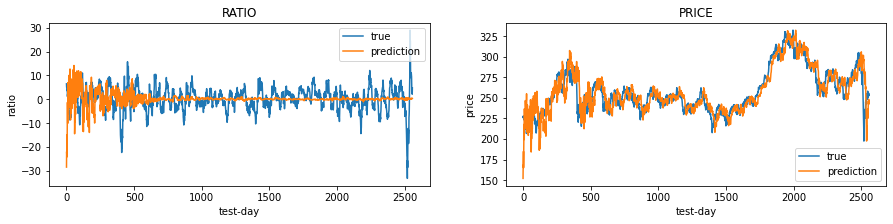

In [21]:
result.evaluation()
result.table(test_open_prices, test_high_prices, test_low_prices, profits, profits2)
result.save_result(model_name,item_name,n_unit,target_type,batch_size,n_timestep,time_interval,epochs,str(alpha),comment)
result.save_visualization()
result.save_model(model2)